<a href="https://colab.research.google.com/github/Ziyi-star/Bachelorarbeit/blob/main/notebooks/training/pretrain_simclr_har_1s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SimCLR Training

In [ ]:
# For VSCode
%load_ext autoreload
%autoreload 2

import os
import pickle
import scipy
import datetime
import numpy as np
import tensorflow as tf
import simclr_utitlities
import transformations
import simclr_models
import sys
import matplotlib.pyplot as plt

sys.path.append('../../')   # Add parent directory to Python path
working_directory = "../../models/"

seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)

# todo: Load data need to be changed according to your path
with open('../data_1s/X_train_normalized.pkl', 'rb') as f:
    np_train_data = pickle.load(f)
with open('../data_1s/y_train_onehot.pkl', 'rb') as f:
    np_train_labels = pickle.load(f)
print(np_train_data.shape, np_train_labels.shape)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


((416, 100, 3), (416, 7))

In [2]:
# For Google Colab
# 1. Clone your repository to go to access your notebook and .py files
!git clone https://github.com/Ziyi-star/Bachelorarbeit.git
# 2. Change working directory to where your notebook and .py files are
import os
os.chdir('/content/Bachelorarbeit/notebooks/training')
import os
import pickle
import scipy
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import simclr_utitlities
import transformations
import simclr_models
import sys

seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)

# Load data
# Download the file from GitHub
!wget https://raw.githubusercontent.com/Ziyi-star/Bachelorarbeit/main/notebooks/data_1s/X_train_normalized.pkl
!wget https://raw.githubusercontent.com/Ziyi-star/Bachelorarbeit/main/notebooks/data_1s/y_train_onehot.pkl

working_directory = "../models/"  # Relative path to models folder

# Load as usual
import pickle

with open('X_train_normalized.pkl', 'rb') as f:
    np_train_data = pickle.load(f)
with open('y_train_onehot.pkl', 'rb') as f:
    np_train_labels = pickle.load(f)

print(np_train_data.shape, np_train_labels.shape)


Cloning into 'Bachelorarbeit'...
remote: Enumerating objects: 261, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 261 (delta 11), reused 17 (delta 6), pack-reused 234 (from 1)
Receiving objects: 100% (261/261), 52.14 MiB | 12.79 MiB/s, done.
Resolving deltas: 100% (123/123), done.
--2025-09-09 11:37:11--  https://raw.githubusercontent.com/Ziyi-star/Bachelorarbeit/main/notebooks/data_1s/X_train_normalized.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 998565 (975K) [application/octet-stream]
Saving to: ‘X_train_normalized.pkl.1’

X_train_normalized. 100%[===================>] 975.16K  --.-KB/s    in 0.008s  

2025-09-09 11:37:12 (121 MB/s) - ‘X_train_normalized.pkl.1’ saved [998565/99856

In [9]:
# Parameters for all experiments
window_size = 100
input_shape = (window_size, 3)
batch_size = 512
#Number of samples processed together in one training step. Larger batch sizes can speed up training but require more memory.
decay_steps = 1000
#Number of steps after which the learning rate decays (used for learning rate scheduling).
epochs = 200
temperature = 0.1


In [10]:
# # transformation_indices = [2] # Use rotation transformation only
# # transformation_indices = [1, 2] # Use Scaling and rotation transformation
# transformation_indices = [5, 7] # Use channel shuffle and permutation transformation

# transform_funcs_vectorized = [
#     # 0. Adding random Gaussian noise.
#     transformations.noise_transform_vectorized,
#     # 1. Scaling by a random factor
#     transformations.scaling_transform_vectorized,
#     # 2. Applying a random 3D rotation
#     transformations.rotation_transform_vectorized,
#     # 3. Inverting the signals.
#     transformations.negate_transform_vectorized,
#     # 4. Reversing the direction of time
#     transformations.time_flip_transform_vectorized,
#     # 5. Randomly scrambling sections of the signal.
#     transformations.time_segment_permutation_transform_improved,
#     # 6. Stretching and warping the time-series
#     transformations.time_warp_transform_low_cost,
#     # 7. Shuffling the different channels.
#     transformations.channel_shuffle_transform_vectorized
# ]
# # transform_funcs_names = ['noised', 'scaled', 'rotated', 'negated', 'time_flipped', 'permuted', 'time_warped', 'channel_shuffled']
# # Optionally, you can use a combined transformation function for data augmentation.
# transformation_function = simclr_utitlities.generate_combined_transform_function(
#     transform_funcs_vectorized,
#     indices=transformation_indices
# )

In [11]:
#A parameter for the SimCLR loss function that controls how sharply similarities are measured.
# transform_funcs = [
#     transformations.scaling_transform_vectorized, # Use Scaling trasnformation
#     transformations.rotation_transform_vectorized # Use rotation trasnformation
# ]
transform_funcs = [
    transformations.time_segment_permutation_transform_improved,
    transformations.channel_shuffle_transform_vectorized
]
#List of data augmentation functions to apply to the input data. Here, only rotation is used.
transformation_function = simclr_utitlities.generate_composite_transform_function_simple(transform_funcs)

0 <function time_segment_permutation_transform_improved at 0x7a55833e5080>
1 <function channel_shuffle_transform_vectorized at 0x7a55833e4fe0>


In [12]:
# Time
start_time = datetime.datetime.now()
start_time_str = start_time.strftime("%Y%m%d-%H%M%S")
#Formats the date and time as a string like 20250827-153045 (for filenames, logs, etc.).
tf.keras.backend.set_floatx('float32')
#Sets TensorFlow to use 32-bit floating point numbers for all computations (standard for deep learning).


In [13]:
# Create a cosine-decayed learning rate schedule and SGD optimizer for training.
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

# Build the base model and attach the SimCLR head for contrastive learning.
base_model = simclr_models.create_base_model(input_shape, model_name="base_model")
simclr_model = simclr_models.attach_simclr_head(base_model)
simclr_model.summary()

# Train the SimCLR model using the specified transformation function and optimizer.
trained_simclr_model, epoch_losses = simclr_utitlities.simclr_train_model(
    simclr_model,
    np_train_data,
    optimizer,
    batch_size,
    transformation_function,
    temperature=temperature,
    epochs=epochs,
    is_trasnform_function_vectorized=True,
    verbose=1
)

# Save the trained SimCLR model to disk for later use.
simclr_model_save_path = f"{working_directory}{start_time_str}_simclr.hdf5"
trained_simclr_model.save(simclr_model_save_path)

Model: "base_model_simclr"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 100, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 77, 32)         │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 77, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 62, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 55, 96)         │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 55, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 96)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         6,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,594 (580.45 KB)

 Trainable params: 148,594 (580.45 KB)

 Non-trainable params: 0 (0.00 B)

epoch: 1 loss: 12.905
epoch: 2 loss: 13.067
epoch: 3 loss: 12.395
epoch: 4 loss: 11.079
epoch: 5 loss: 9.919
epoch: 6 loss: 9.785
epoch: 7 loss: 9.848
epoch: 8 loss: 10.794
epoch: 9 loss: 10.944
epoch: 10 loss: 10.448
epoch: 11 loss: 10.107
epoch: 12 loss: 9.801
epoch: 13 loss: 9.671
epoch: 14 loss: 9.563
epoch: 15 loss: 9.629
epoch: 16 loss: 9.504
epoch: 17 loss: 9.701
epoch: 18 loss: 9.685
epoch: 19 loss: 9.743
epoch: 20 loss: 9.197
epoch: 21 loss: 9.047
epoch: 22 loss: 9.103
epoch: 23 loss: 9.218
epoch: 24 loss: 9.671
epoch: 25 loss: 9.632
epoch: 26 loss: 9.191
epoch: 27 loss: 9.156
epoch: 28 loss: 9.035
epoch: 29 loss: 9.771
epoch: 30 loss: 11.101
epoch: 31 loss: 10.028
epoch: 32 loss: 9.549
epoch: 33 loss: 9.208
epoch: 34 loss: 9.000
epoch: 35 loss: 9.175
epoch: 36 loss: 9.052
epoch: 37 loss: 8.711
epoch: 38 loss: 8.608
epoch: 39 loss: 8.856
epoch: 40 loss: 9.152
epoch: 41 loss: 8.763
epoch: 42 loss: 8.412
epoch: 43 loss: 8.912
epoch: 44 loss: 9.601
epoch: 45 loss: 9.202
epoch: 46

epoch: 200 loss: 6.620


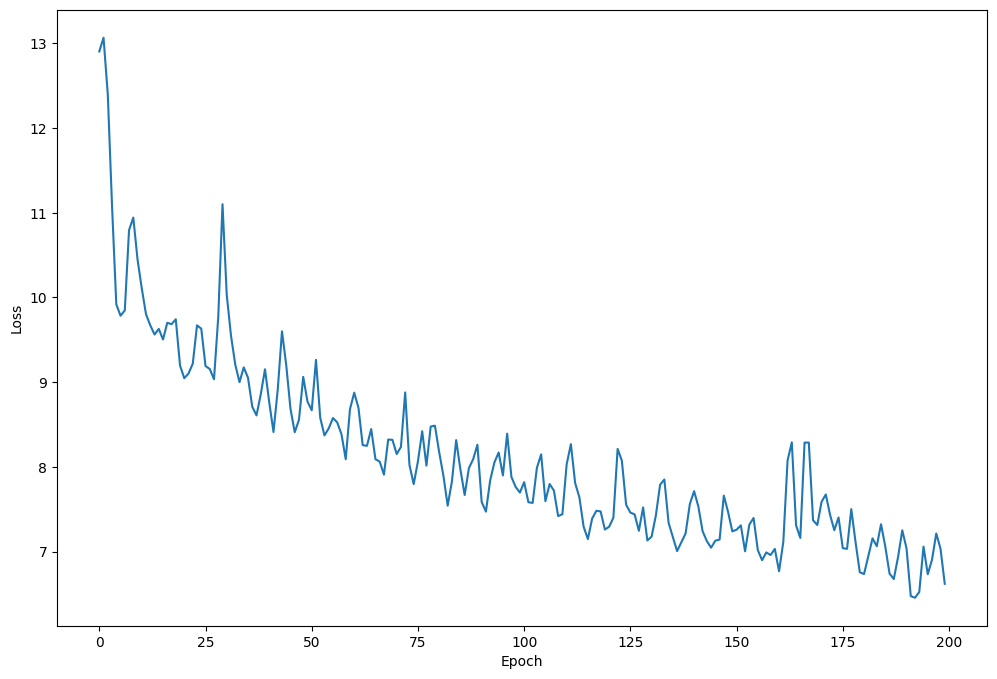

In [14]:
plt.figure(figsize=(12,8))
plt.plot(epoch_losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()